In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using Revise
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [3]:
includet("../VARs/utils.jl")
includet("../VARs/VAR_OLS.jl")

In [4]:
df = DataFrame(XLSX.readtable("../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :observation_date), Dates.year, first)

display(returns_summarystats(data_source, 1)) 

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
A939RX0Q048SBEA,14838.8,67981.0,40071.6,53710.0,18032.0,0.1487,27121.5,0.9563,-1.2441,2.7005,39549.5
GDPDEF,32.924,124.163,56.7996,84.971,13.675,0.1863,22.07,0.9554,-1.2062,1.7252,57.425
TB3MS,3.1828,14.39,4.2329,5.715,0.03,0.9527,1.83,0.8685,1.1797,1.3299,4.14
GS10,2.9018,14.29,5.5779,7.3375,1.32,0.9058,3.6525,0.9254,0.4925,1.9222,4.875
Price_10Y,1702.69,5318.51,1614.35,2728.29,111.433,0.8088,182.823,0.968,-0.85,0.9481,754.307
Stock_Price,1152.53,5011.96,878.65,1298.47,36.79,1.8412,94.365,0.8845,2.9751,0.7624,312.225
Dividend,18.1203,70.6511,16.8296,22.4625,1.5533,1.4839,3.1642,0.9247,1.2524,0.9288,10.5633
E,47.2349,197.883,40.1674,57.9025,2.8333,1.6449,5.9717,0.8601,2.19,0.8504,17.21
CAPE,8.1444,42.1856,21.0209,26.6211,7.1818,0.4211,15.8277,0.9012,-0.3,2.581,20.674
USACPIALLQINMEI,35.8054,130.944,55.1616,85.458,11.265,0.2918,17.5866,0.9546,-1.1771,1.5406,52.6755


nothing

In [5]:
freq = 1

cpi = percentchange(data_source[:USACPIALLQINMEI], :log) .* 100
nominal_gdp = percentchange(data_source[:NGDPSAXDCUSQ], :log) .* 100 
gdp = nominal_gdp .- cpi

sr = (data_source[:TB3MS]) .- cpi
term = (data_source[:GS10]) .- (data_source[:TB3MS])
Δd = round.(percentchange(data_source[:Dividend], :log) .* 100, digits=2) .- cpi

dy = round.((log.(data_source[:Dividend]) .- log.(data_source[:Stock_Price])), digits=2)

data= merge(gdp, cpi, sr, term, Δd, dy)

start = Date(1985, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data, start),end_d)

display(returns_summarystats(s_data, freq)) 
display(cor(values(s_data)))



,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
NGDPSAXDCUSQ_USACPIALLQINMEI,1.5916,4.9744,2.2035,3.1259,-2.4211,-0.8217,1.6484,0.3595,1.1406,1.3845,2.2274
USACPIALLQINMEI,1.4714,7.6653,2.7745,3.2265,-0.0627,0.919,1.8528,0.3868,1.9097,1.8856,2.7396
TB3MS_USACPIALLQINMEI,2.3673,4.6585,0.4475,2.2531,-7.3553,-0.6496,-1.0958,0.5882,1.1485,0.189,0.6155
GS10_TB3MS,1.224,3.61,1.6328,2.7025,-1.07,-0.2468,0.6675,0.491,-0.5856,1.3339,1.655
Dividend_USACPIALLQINMEI,6.5797,14.6122,2.9522,7.0865,-24.8231,-1.7298,-0.2485,0.4301,6.1945,0.4487,2.8989
Dividend_Stock_Price,0.3321,-3.17,-3.8705,-3.5925,-4.42,0.3718,-4.1,0.7846,-0.8387,-11.6556,-3.925


nothing

6×6 Matrix{Float64}:
  1.0        -0.0786054   0.288259   -0.0434402   0.262786   -0.161539
 -0.0786054   1.0        -0.133999   -0.227563   -0.0864749   0.101584
  0.288259   -0.133999    1.0        -0.228599    0.0530847   0.374547
 -0.0434402  -0.227563   -0.228599    1.0        -0.276802    0.372277
  0.262786   -0.0864749   0.0530847  -0.276802    1.0         0.0551805
 -0.161539    0.101584    0.374547    0.372277    0.0551805   1.0

In [6]:
s_data

40×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1985-01-01 to 2024-01-01
┌────────────┬──────────────────────────────┬─────────────────┬─────────────────
│            │ NGDPSAXDCUSQ_USACPIALLQINMEI │ USACPIALLQINMEI │ TB3MS_USACPIAL ⋯
├────────────┼──────────────────────────────┼─────────────────┼─────────────────
│ 1985-01-01 │                      4.39872 │          3.5215 │                ⋯
│ 1986-01-01 │                      3.32267 │         3.03617 │                ⋯
│ 1987-01-01 │                      2.47021 │         2.17333 │                ⋯
│ 1988-01-01 │                      3.27952 │          3.8945 │                ⋯
│ 1989-01-01 │                       3.5666 │         4.71203 │                ⋯
│ 1990-01-01 │                       1.2517 │         5.10057 │                ⋯
│ 1991-01-01 │                     -2.42109 │         5.15016 │              0 ⋯
│ 1992-01-01 │                        2.463 │         2.82806 │                ⋯
│     ⋮      │              ⋮     

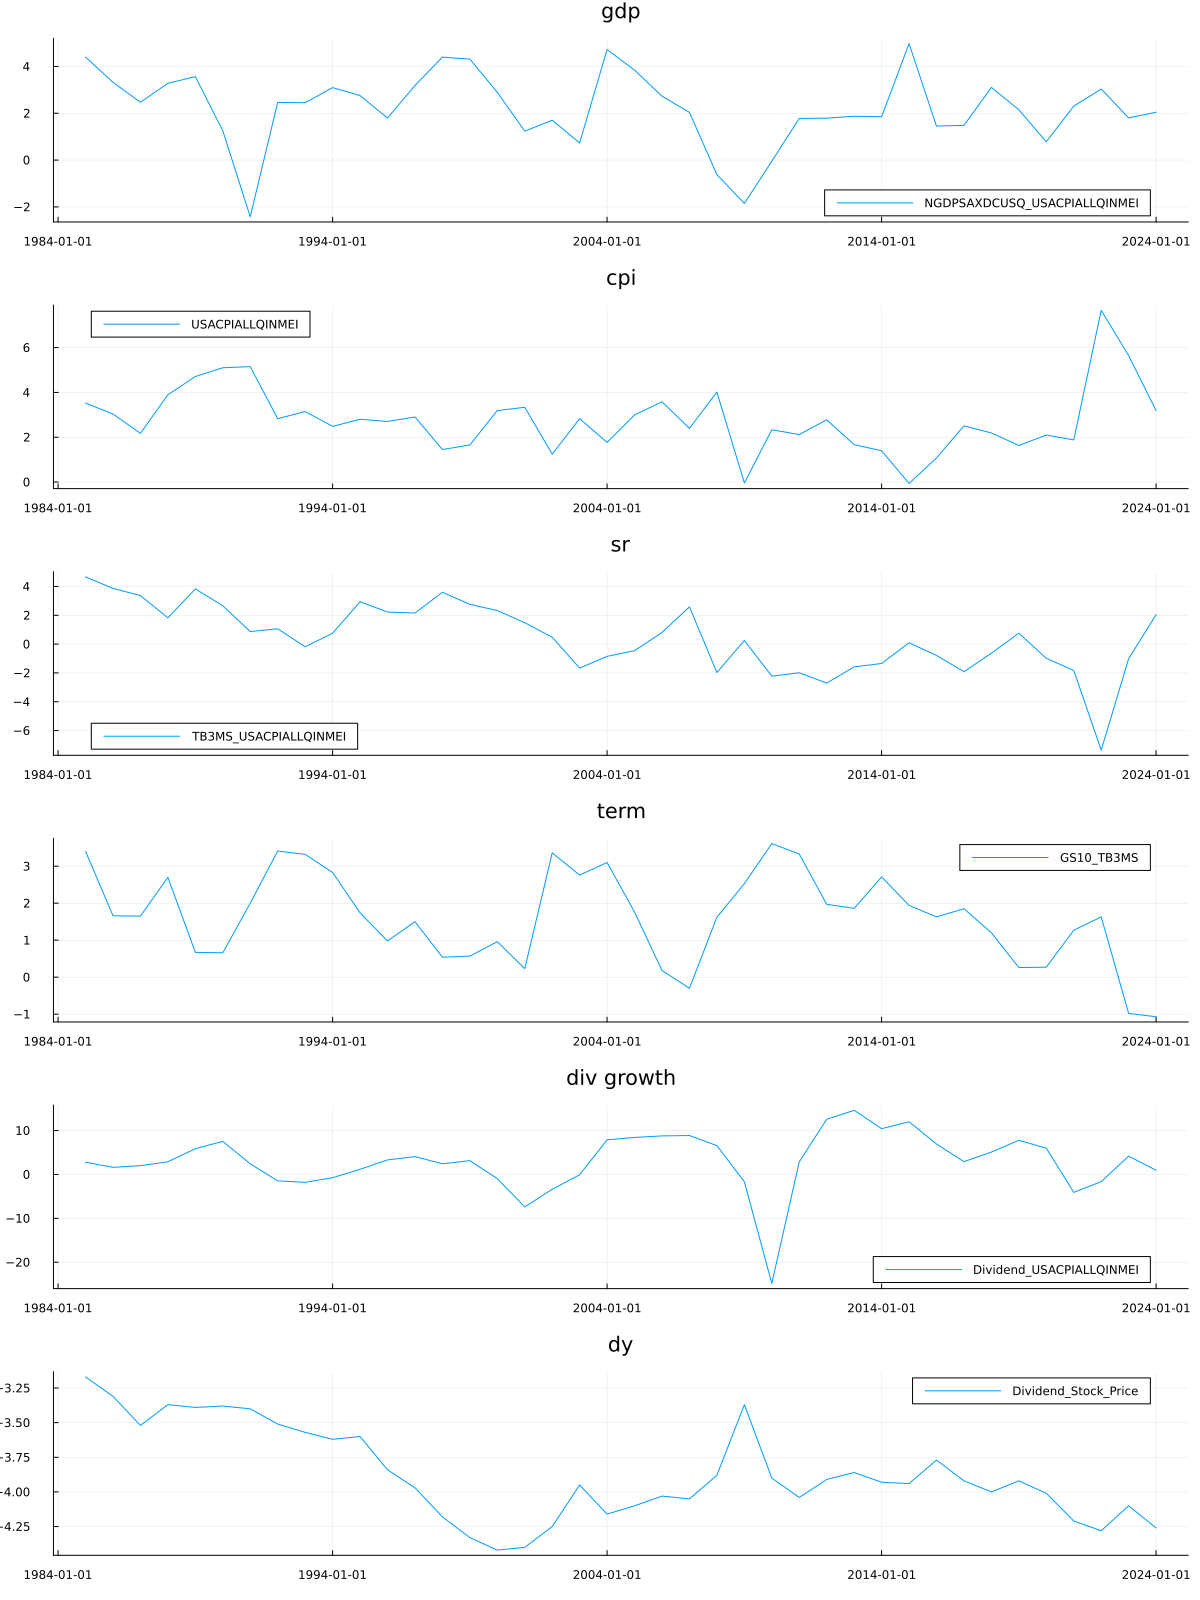

In [7]:
plot(s_data; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [8]:
assets_names = colnames(s_data)
T, n_assets = size(s_data)
model = VARModel(s_data)
model_summary(model)

,const,NGDPSAXDCUSQ_USACPIALLQINMEI,USACPIALLQINMEI,TB3MS_USACPIALLQINMEI,GS10_TB3MS,Dividend_USACPIALLQINMEI,Dividend_Stock_Price,std
NGDPSAXDCUSQ_USACPIALLQINMEI,-1.2875,0.3677,-0.0348,0.0091,0.41,-0.016,-0.5351,1.4712
USACPIALLQINMEI,7.3763,0.3554,0.2643,-0.1127,-0.3679,-0.078,1.3546,1.3478
TB3MS_USACPIALLQINMEI,-3.5188,0.2749,0.7531,0.6361,0.3487,0.0439,-0.0482,1.4952
GS10_TB3MS,1.1137,-0.4749,-0.1879,0.1655,0.5667,-0.0021,-0.2632,0.6918
Dividend_USACPIALLQINMEI,-15.6073,1.4947,0.8908,-0.5304,1.3719,0.4452,-2.4207,5.454
Dividend_Stock_Price,-1.6583,-0.0057,0.0497,0.014,0.0728,0.0099,0.6512,0.1564


,NGDPSAXDCUSQ_USACPIALLQINMEI,USACPIALLQINMEI,TB3MS_USACPIALLQINMEI,GS10_TB3MS,Dividend_USACPIALLQINMEI,Dividend_Stock_Price
NGDPSAXDCUSQ_USACPIALLQINMEI,1.0,-0.17,0.35,-0.13,0.19,-0.56
USACPIALLQINMEI,-0.17,1.0,-0.75,0.01,-0.16,0.0
TB3MS_USACPIALLQINMEI,0.35,-0.75,1.0,-0.35,-0.02,-0.19
GS10_TB3MS,-0.13,0.01,-0.35,1.0,0.09,0.35
Dividend_USACPIALLQINMEI,0.19,-0.16,-0.02,0.09,1.0,0.18
Dividend_Stock_Price,-0.56,0.0,-0.19,0.35,0.18,1.0


In [26]:
#unconditional mean
c = model.C[1,:]
Β = model.C[2:end,:]

uμ = inv(I(6) - Β) * c



6-element Vector{Float64}:
 -11.156213470415947
  22.975005498849086
   9.508876991797592
 -46.45688179439267
 -24.663391644234835
 306.4888397540369

In [10]:
scenarios = simulate(model, 25*freq, 10_000)
#periods = [2,6, 16, 26]
periods = [1,5, 15, 25]
ret_in_years = cum_returns_in_periods(scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:n_assets
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

,NGDPSAXDCUSQ_USACPIALLQINMEI,USACPIALLQINMEI,TB3MS_USACPIALLQINMEI,GS10_TB3MS,Dividend_USACPIALLQINMEI,Dividend_Stock_Price
1,2.0446,3.1896,2.0404,-1.07,0.9604,-4.26
5,1.8526,2.781,0.323,0.8451,0.5247,-4.2615
15,2.0419,2.6065,-0.2432,1.2233,2.5935,-4.1366
25,2.0583,2.5936,-0.3287,1.3096,2.867,-4.1015


,NGDPSAXDCUSQ_USACPIALLQINMEI,USACPIALLQINMEI,TB3MS_USACPIALLQINMEI,GS10_TB3MS,Dividend_USACPIALLQINMEI,Dividend_Stock_Price
1,0.0,0.0,0.0,0.0,0.0,0.0
5,0.7562,0.7642,0.882,0.5972,3.4007,0.1473
15,0.4783,0.5387,0.7512,0.4121,2.2667,0.1597
25,0.3818,0.4322,0.6414,0.3339,1.7806,0.1412


,NGDPSAXDCUSQ_USACPIALLQINMEI,USACPIALLQINMEI,TB3MS_USACPIALLQINMEI,GS10_TB3MS,Dividend_USACPIALLQINMEI,Dividend_Stock_Price
1,-1.0,-1.0,1.0,1.0,1.0,1.0
5,-0.0092,0.0183,-0.0243,0.0325,0.0195,0.0341
15,0.0578,0.0018,0.0175,0.0122,0.0022,0.0283
25,0.0819,-0.0053,0.0387,-0.0165,0.0056,-0.0087


,NGDPSAXDCUSQ_USACPIALLQINMEI,USACPIALLQINMEI,TB3MS_USACPIALLQINMEI,GS10_TB3MS,Dividend_USACPIALLQINMEI,Dividend_Stock_Price
1,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
5,-0.0018,-0.0535,-0.0675,0.0818,-0.0521,0.0123
15,0.023,-0.0143,0.0849,-0.0247,-0.0601,-0.0405
25,0.0695,0.0379,-0.0315,-0.0194,-0.0145,0.0053


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,2.0446,2.0446,2.0446,2.0446,2.0446,2.0446,2.0446,2.0446,2.0446
5,0.0951,0.3921,0.5958,1.342,1.8636,2.3566,3.0928,3.3343,3.6243
15,0.9318,1.1153,1.2702,1.7168,2.035,2.3586,2.8376,2.9946,3.1906
25,1.1785,1.3223,1.4452,1.7985,2.0489,2.3107,2.697,2.8309,2.972


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,3.1896,3.1896,3.1896,3.1896,3.1896,3.1896,3.1896,3.1896,3.1896
5,1.0112,1.2855,1.5349,2.2599,2.7754,3.303,4.0412,4.266,4.5356
15,1.3609,1.5448,1.72,2.2447,2.5972,2.9694,3.4957,3.6602,3.863
25,1.589,1.7476,1.8894,2.3055,2.5927,2.8814,3.3015,3.4422,3.5971


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,2.0404,2.0404,2.0404,2.0404,2.0404,2.0404,2.0404,2.0404,2.0404
5,-1.715,-1.3975,-1.1448,-0.2772,0.3377,0.9147,1.7715,2.0475,2.3363
15,-1.9726,-1.7023,-1.4725,-0.7515,-0.2441,0.2591,0.991,1.2304,1.5227
25,-1.7902,-1.5631,-1.3594,-0.7723,-0.3231,0.095,0.7377,0.9438,1.2061


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-1.07,-1.07,-1.07,-1.07,-1.07,-1.07,-1.07,-1.07,-1.07
5,-0.5585,-0.3237,-0.1144,0.446,0.841,1.2471,1.8212,2.0324,2.2658
15,0.2792,0.4285,0.5464,0.9438,1.2221,1.4942,1.9048,2.0447,2.179
25,0.5319,0.6574,0.76,1.0834,1.3095,1.5369,1.8575,1.9672,2.091


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,0.9604,0.9604,0.9604,0.9604,0.9604,0.9604,0.9604,0.9604,0.9604
5,-7.3073,-6.0856,-5.0215,-1.8092,0.5393,2.8329,6.1289,7.1892,8.5191
15,-2.6337,-1.8068,-1.1135,1.0402,2.5854,4.1379,6.3365,7.04,7.802
25,-1.1735,-0.6112,-0.0532,1.6645,2.8559,4.0862,5.7721,6.3093,7.0703


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26,-4.26
5,-4.6025,-4.5434,-4.5001,-4.3632,-4.2622,-4.161,-4.0206,-3.9775,-3.9178
15,-4.5049,-4.4473,-4.3969,-4.2448,-4.1359,-4.0303,-3.8723,-3.8209,-3.7614
25,-4.4367,-4.3761,-4.3324,-4.1965,-4.101,-4.0067,-3.8677,-3.8227,-3.7774


In [11]:
sr = scenarios[2, :,:] + scenarios[3, :,:] 
lr = scenarios[2, :,:] + scenarios[3, :,:] + scenarios[4, :,:] 
real_Δd = scenarios[2, :,:] + scenarios[5, :,:]
dy = exp.(scenarios[6, :,:])



print_scenarios_percentiles(sr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "sr")
print_scenarios_percentiles(lr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "lr")
print_scenarios_percentiles(cumsum(real_Δd, dims=1)[periods,:] ./ (periods.-1), [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "Δd")
print_scenarios_percentiles(dy[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "dy")



,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.23,5.23,5.23,5.23,5.23,5.23,5.23,5.23,5.23
5,-3.0952,-2.2934,-1.6175,0.4039,1.8111,3.1674,5.2364,5.9305,6.7151
15,-3.109,-2.2138,-1.5358,0.6218,2.0941,3.5867,5.7,6.3361,7.1792
25,-2.8857,-2.1747,-1.4734,0.6746,2.1449,3.6126,5.7801,6.4864,7.2202


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16
5,0.0619,0.6431,1.0807,2.5085,3.478,4.4797,5.9603,6.4569,7.0074
15,-0.3651,0.1883,0.7382,2.3823,3.501,4.6345,6.2472,6.7756,7.4031
25,-0.3888,0.3283,0.8235,2.466,3.5713,4.6732,6.2801,6.8013,7.481


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf
5,-5.4817,-4.0643,-2.7222,1.3129,4.1213,6.9448,11.0013,12.2145,13.8456
15,0.2215,1.0901,1.8037,4.0107,5.5511,7.1607,9.4181,10.1326,10.8564
25,1.5967,2.2396,2.8281,4.5053,5.6732,6.8712,8.5556,9.0855,9.7898


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141,0.0141
5,0.0082,0.0091,0.0099,0.0128,0.0153,0.0184,0.024,0.0259,0.0288
15,0.0089,0.0098,0.0107,0.0142,0.0174,0.0212,0.0279,0.0304,0.0344
25,0.0089,0.0098,0.0107,0.0142,0.0175,0.0214,0.0282,0.031,0.0343


In [12]:
real_Δd[1,:] .= 1.

div_index =values(data_source[:Dividend][end])[1] .* exp.(cumsum(real_Δd, dims=1) ./100)

price_index = div_index ./ dy
periods = [1, 5, 10, 25] * freq

eq_ret = log.((price_index[2:end,:] .+ div_index[2:end,:] ) ./ price_index[1:end-1,:])
eq_cum_ret = cumsum(eq_ret, dims=1)[periods,:] ./ periods
real_eq_ret = eq_ret .- (scenarios[2, 2:end, :] ./100)
real_eq_cum_ret = cumsum(real_eq_ret, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(eq_cum_ret, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity return")
print_scenarios_percentiles(real_eq_cum_ret, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity real return") 

,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.258,-0.2068,-0.1557,-0.0071,0.1022,0.2049,0.3522,0.402,0.4611
5,-0.1043,-0.0836,-0.0655,-0.0112,0.0262,0.0636,0.1162,0.1357,0.1563
10,-0.0323,-0.0201,-0.009,0.0239,0.0466,0.0697,0.1025,0.1134,0.1241
25,0.0184,0.0253,0.0319,0.0511,0.0639,0.0772,0.0963,0.1024,0.1094


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.2903,-0.2403,-0.1904,-0.0384,0.0686,0.1717,0.3203,0.3689,0.4339
5,-0.1304,-0.1127,-0.0934,-0.0383,-0.0001,0.0383,0.0929,0.1123,0.1335
10,-0.0604,-0.0486,-0.0374,-0.0027,0.021,0.045,0.0792,0.0911,0.1036
25,-0.0098,-0.0021,0.0041,0.0245,0.0382,0.0525,0.0719,0.0786,0.0866


In [13]:
mdd, mddl = max_drawdown_and_length(real_eq_ret)

display("real equity")
display("mdd")
display(quantile(mdd, [.05, .25, .5, .75, .95])')
display("mddl")
display(quantile(mddl, [.05, .25, .5, .75, .95])')

"real equity"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.234218  0.323774  0.396572  0.476796  0.589304

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 5.0  7.0  9.0  12.0  19.0

In [14]:
eq_return = calculate_equity_returns(real_Δd, scenarios[6, :,:])
eq_cum_return = cumsum(eq_return, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(eq_cum_return, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity return")

,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.258,-0.2068,-0.1557,-0.0071,0.1022,0.2049,0.3522,0.402,0.4611
5,-0.1043,-0.0836,-0.0655,-0.0112,0.0262,0.0636,0.1162,0.1357,0.1563
10,-0.0323,-0.0201,-0.009,0.0239,0.0466,0.0697,0.1025,0.1134,0.1241
25,0.0184,0.0253,0.0319,0.0511,0.0639,0.0772,0.0963,0.1024,0.1094


In [15]:
percentile(eq_return[1,:], [.25, .5, .75])

3-element Vector{Float64}:
 -0.33102230557496937
 -0.2893896418605733
 -0.27471891332202275

In [16]:
bond_returns = calculate_bond_returns(lr./100, 10, 1)
bond_cum_returns = cumsum(bond_returns, dims=1)[periods,:] ./ periods

real_bond_returns = bond_returns .- (scenarios[2, 2:end, :] ./100)
real_bond_cum_returns = cumsum(real_bond_returns, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "bonds returns")
print_scenarios_percentiles(real_bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "real bonds returns")


mdd, mddl = max_drawdown_and_length(real_bond_returns)

display("real bonds")
display("mdd")
display(quantile(mdd, [.05, .25, .5, .75, .95])')
display("mddl")
display(quantile(mddl, [.05, .25, .5, .75, .95])')


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.1091,-0.091,-0.071,-0.0115,0.0328,0.0789,0.152,0.175,0.2035
5,0.0119,0.0178,0.0229,0.0405,0.0534,0.0671,0.0886,0.0967,0.1057
10,0.0197,0.0235,0.0263,0.0364,0.0437,0.0517,0.0639,0.0679,0.0724
25,0.0206,0.0237,0.0262,0.0339,0.0393,0.045,0.0531,0.0559,0.0587


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.1527,-0.1311,-0.1126,-0.0477,0.0002,0.0494,0.1278,0.1534,0.1808
5,-0.0264,-0.0186,-0.0114,0.0109,0.0272,0.0443,0.0708,0.0809,0.0922
10,-0.0116,-0.0072,-0.0032,0.009,0.018,0.0276,0.0423,0.0469,0.0522
25,-0.0035,-0.001,0.0013,0.0085,0.0137,0.0189,0.0266,0.0292,0.0321


"real bonds"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.14227  0.207418  0.261763  0.324881  0.424584

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 6.0  8.0  11.0  15.0  20.0

In [17]:
B = collect(model.C[2:end,:]')

resp = girf(B, model.Σ, 10, 1, 1)



11×6 Matrix{Float64}:
  1.47119     -0.2271       0.524065   -0.0868084   1.01363    -0.0873666
  0.548617     0.238277     0.585203   -0.597589    2.26239    -0.0655428
 -0.04732      0.146574     0.596612   -0.534597    1.06785    -0.0469796
 -0.228185     0.00442008   0.339623   -0.199156   -0.40093    -0.0430926
 -0.133164    -0.0720301    0.0716777   0.0630559  -0.864648   -0.040252
  0.0153962   -0.0847143   -0.0592831   0.136768   -0.50218    -0.0319693
  0.0892741   -0.0646851   -0.0700906   0.0857647   0.0204665  -0.020939
  0.080481    -0.0389827   -0.0369478   0.0122318   0.290451   -0.0118897
  0.0373507   -0.0207995   -0.0131512  -0.0275527   0.280024   -0.00689666
  0.00225824  -0.0117896   -0.0107469  -0.0303874   0.147823   -0.00516311
 -0.0109148   -0.00844686  -0.0189536  -0.0168047   0.0351854  -0.00486389

In [18]:
resp[2,2] + resp[2,3]  + resp[2,4]

0.22589023208654668

gdp + 
- sr .42
- lr .25

gdp -
- sr - .42
- lr - .25

cpi +
- sr .09
- lr .2


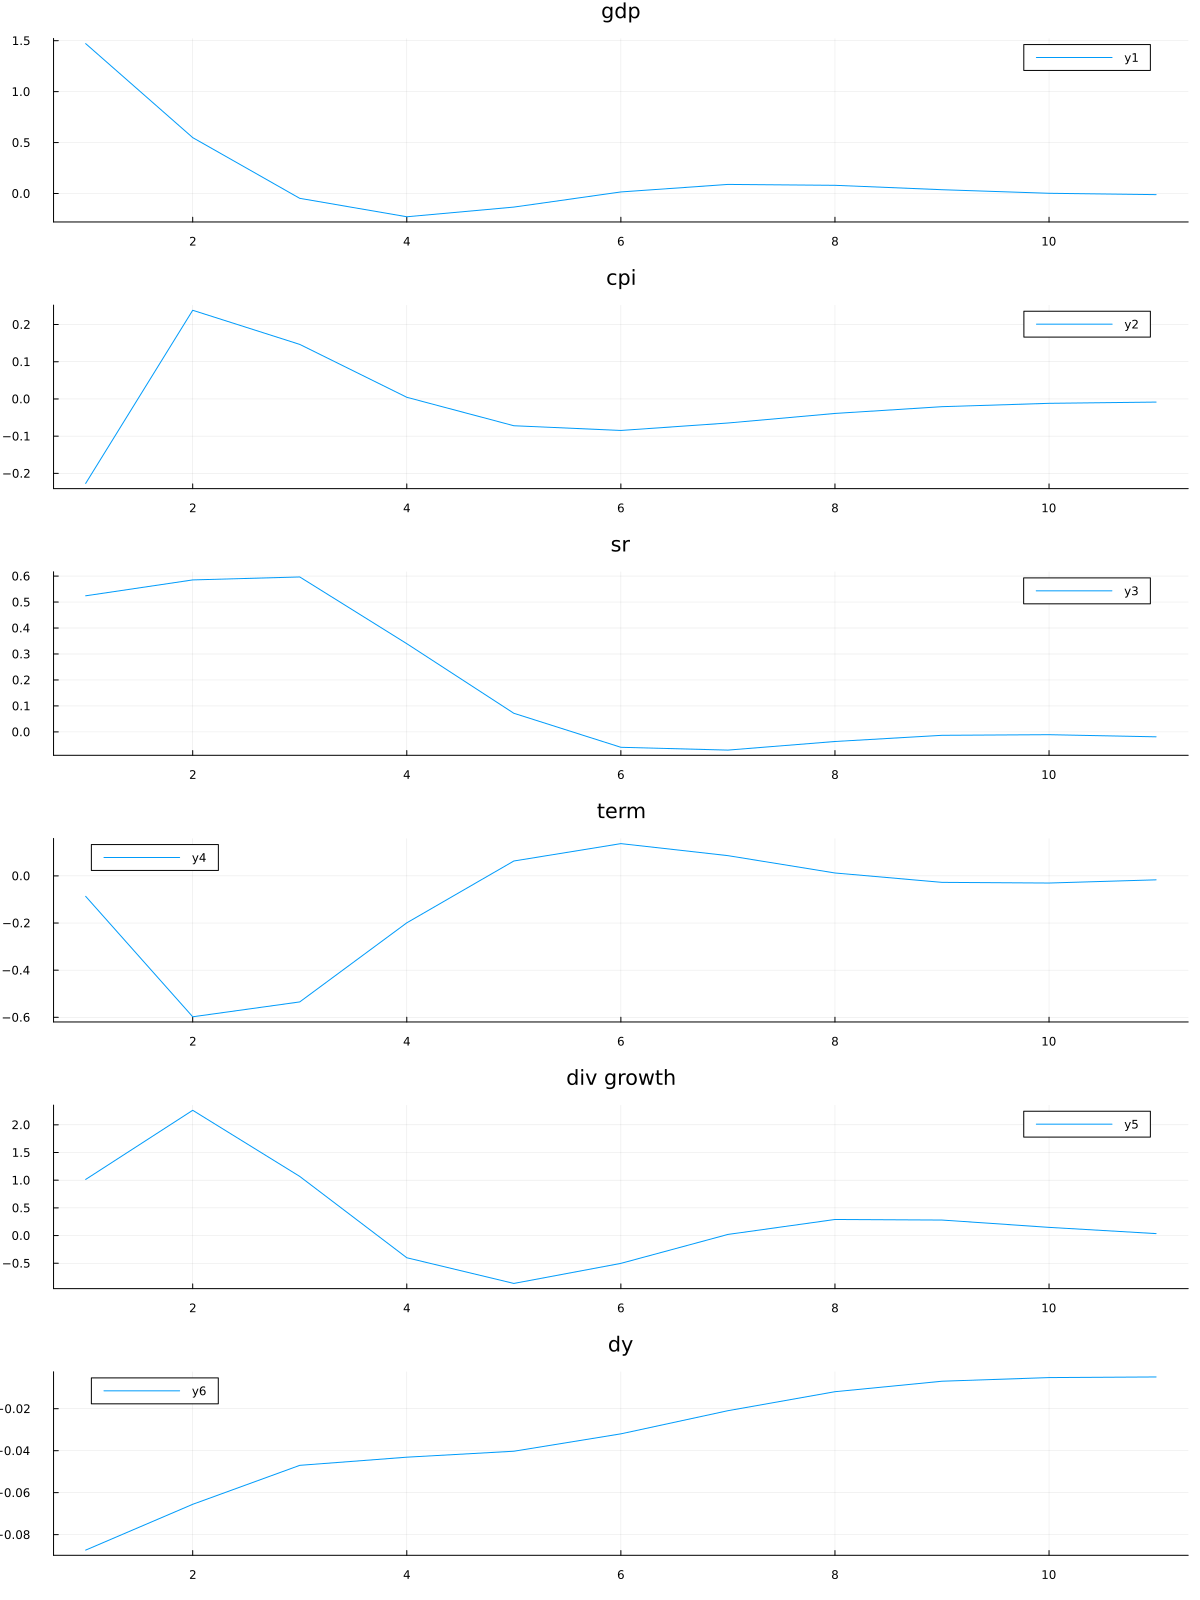

In [19]:
plot(resp; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [20]:
display(exp(-3.8 ) *100) 
display(exp(-3.8 + 0.08)*100) 
display((exp(-3.8 ) - exp(-3.8 + 0.08))*100) 
display(0.0224*exp((0.06^2)-1)^.5 *100)
display(exp(-4.8 ) *100) 

2.23707718561656

2.4233967845691122

-0.1863195989525522

1.3610764116758998

0.822974704902003

IRF returns
- estimate dy, and div idnex, based on initial value, mean?
- estimate returns?
- 

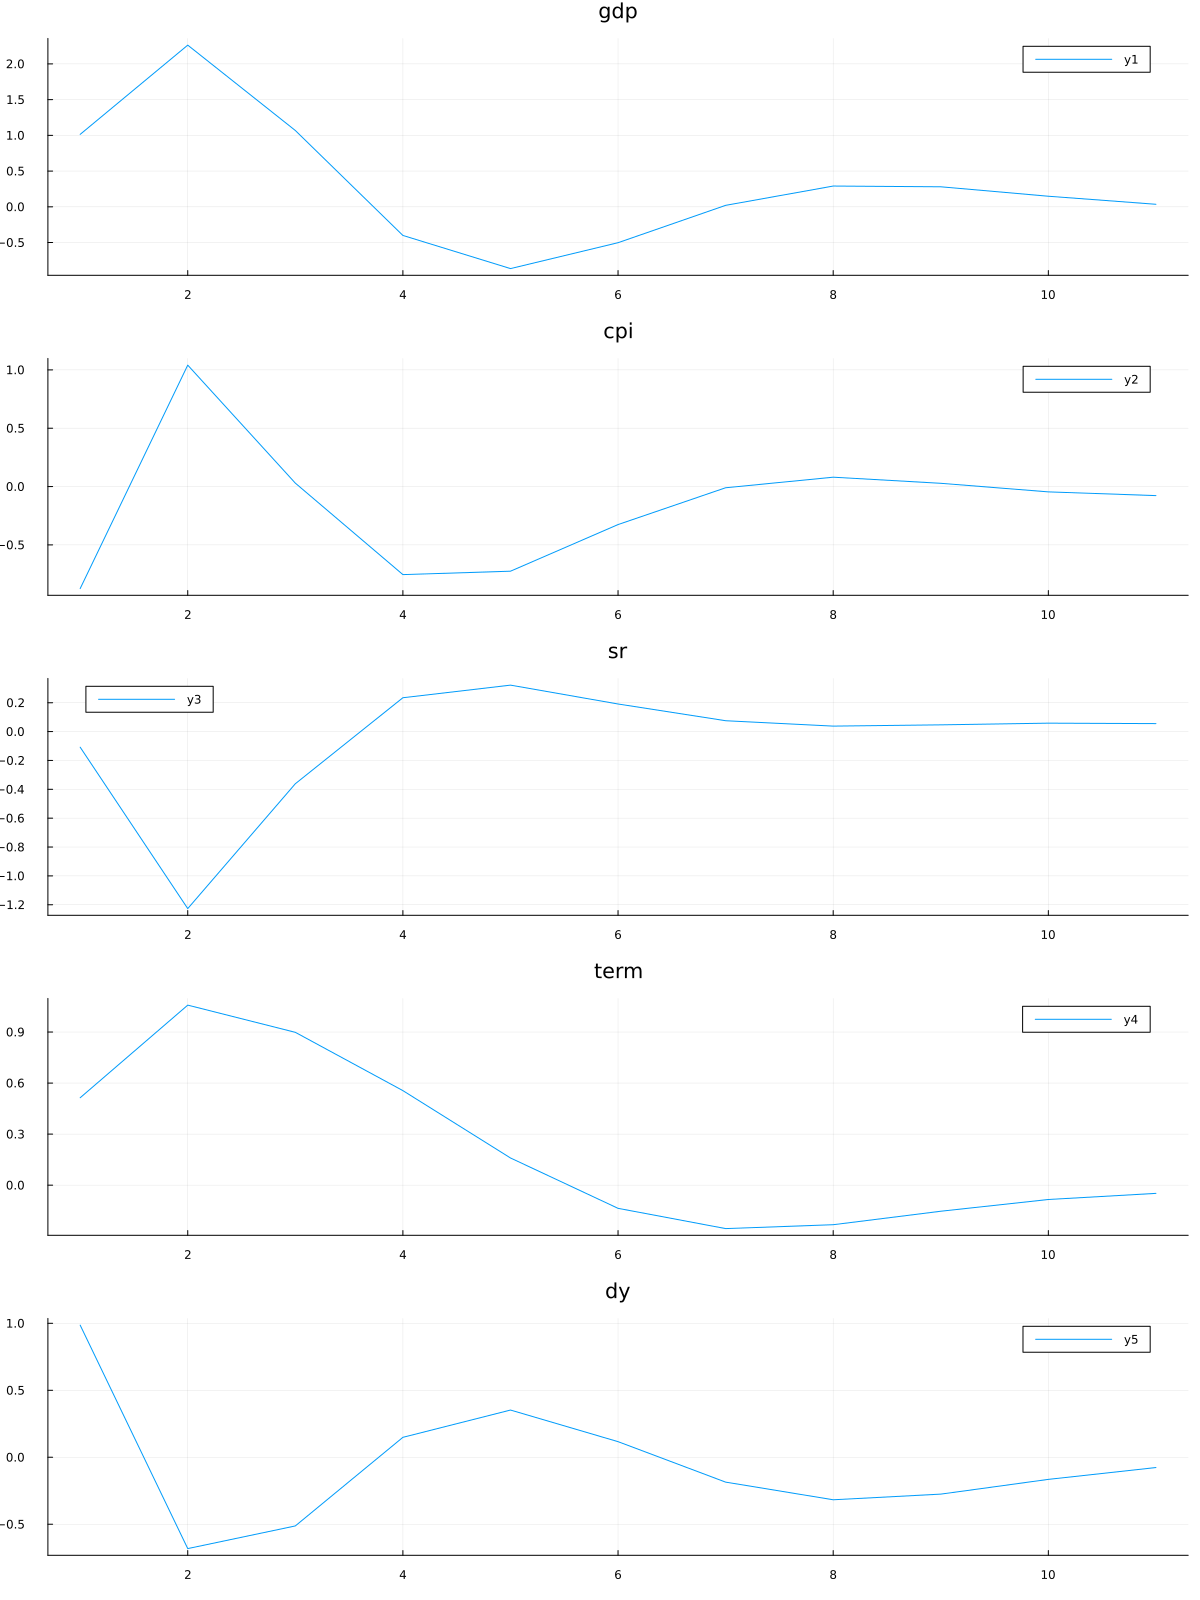

In [21]:
# div growth irf

B = collect(model.C[2:end,:]')

variables = [1,2,3,4,6]
result = zeros(11,5)

for (index, v) in enumerate(variables)
    resp = girf(B, model.Σ, 10, v, 1)
    result[:,index] = resp[:,5]
end

plot(result; layout = (5,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "dy"])



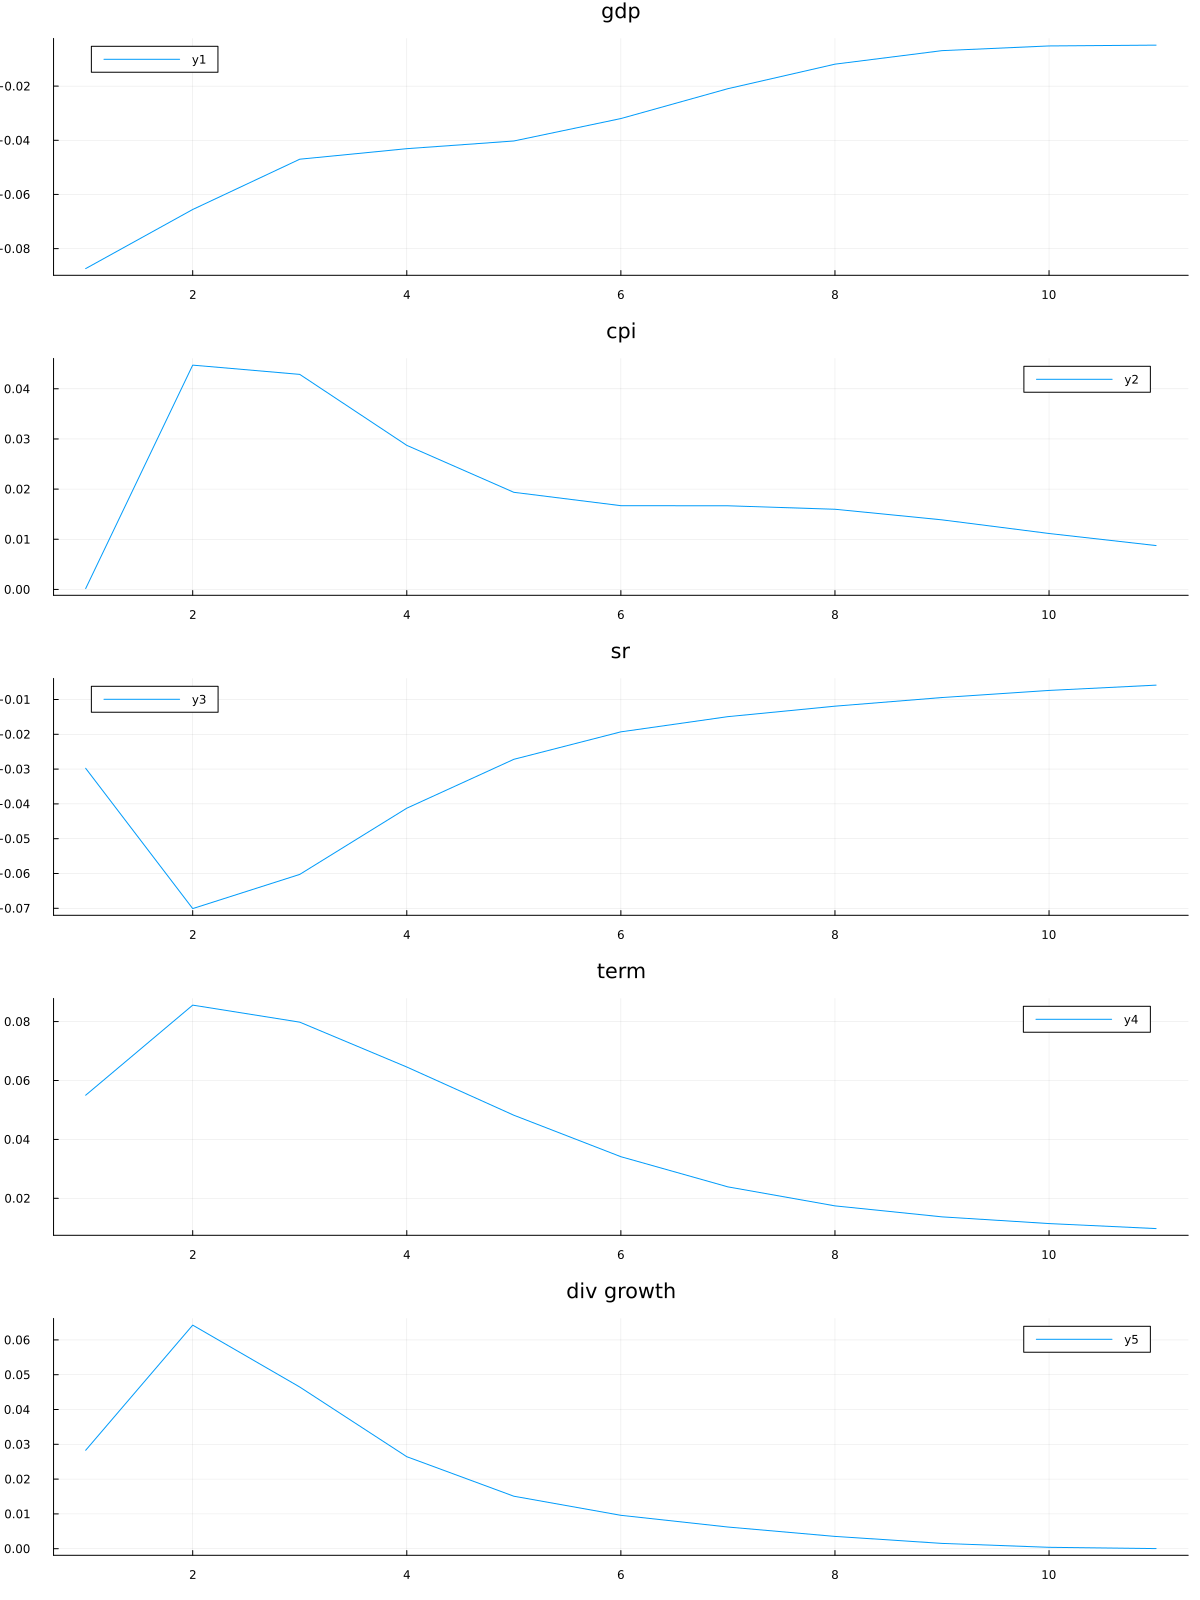

In [27]:
# div yeld irf

B = collect(model.C[2:end,:]')

variables = [1,2,3,4,5]
result = zeros(11,5)

for (index, v) in enumerate(variables)
    resp = girf(B, model.Σ, 10, v, 1)
    result[:,index] = resp[:,6]
end

plot(result; layout = (5,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth"])

In [23]:
real_Δd = resp[:,2] + resp[:,5]




11-element Vector{Float64}:
  5.237846166249347
  2.312890285024953
  0.3749950164221478
 -0.15306768047653313
 -0.04491512419825229
  0.09780425530661947
  0.09906780055056136
  0.022223780293744035
 -0.039820175449660544
 -0.05321154821982271
 -0.03405511039439329

In [24]:
dy = exp.(scenarios[6, :,:])

26×10000 Matrix{Float64}:
 0.0141223  0.0141223   0.0141223  …  0.0141223  0.0141223  0.0141223
 0.0139958  0.0084289   0.0118178     0.0142221  0.012614   0.0133608
 0.0105317  0.00879208  0.0142259     0.0118077  0.0135335  0.0145749
 0.0143903  0.0115316   0.016609      0.0130269  0.0231584  0.0186825
 0.0140624  0.0156853   0.0153866     0.0114424  0.0254388  0.0198146
 0.015339   0.0138607   0.0140904  …  0.0133598  0.0216384  0.0178642
 0.0187144  0.0155633   0.0108072     0.0165033  0.0249429  0.0181031
 0.0193862  0.0154972   0.0120512     0.0166565  0.0235952  0.0200851
 0.0186801  0.0147975   0.0139581     0.0147523  0.0204829  0.0166854
 0.0197851  0.0131372   0.0193166     0.0127007  0.0228309  0.014699
 ⋮                                 ⋱                        
 0.0253083  0.0168298   0.0230435     0.0220693  0.0183838  0.0203854
 0.0227721  0.0115828   0.0189877     0.0165483  0.0173068  0.0192043
 0.0181252  0.0103471   0.0172807     0.0177503  0.0174488  0.0204029
 0.0